In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

warnings.filterwarnings("ignore")

import tensorflow as tf
# Adjust these numbers based on your CPU cores.
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(8)

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import keras_tuner as kt

Data Loading and Preprocessing

In [3]:
def load_and_preprocess_data(filepath):
    # Load raw CSV data
    df = pd.read_csv(filepath)
    
    # Drop exact duplicate rows (after cleaning string columns)
    df_clean = df.copy()
    for col in df_clean.select_dtypes(include='object'):
        df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()
    df_clean = df_clean.drop_duplicates()
    
    # Remove outliers in numeric columns using the IQR method
    num_cols = df_clean.select_dtypes(include=np.number).columns
    for col in num_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5* IQR
        upper_bound = Q3 + 1.5* IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    # Create a working copy for model training that encodes categorical data.
    df_model = df_clean.copy()
    
    # Print some info
    print("Dataset Info:")
    print(f"Original rows: {df.shape[0]}, Rows after cleaning duplicates and removing outliers: {df_clean.shape[0]}")
    print(df_clean.info(), "\n")
    
    # One-hot encode selected columns (drop the first to avoid dummy variable trap)
    cat_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)
    
    # Label encoding the target (the target column is 'Status')
    label_encoder = LabelEncoder()
    df_model['Status'] = label_encoder.fit_transform(df_model['Status'])
    
    # Fill numeric missing values with the column mean
    for col in df_model.select_dtypes(include=np.number).columns:
        df_model[col].fillna(df_model[col].mean(), inplace=True)
    
    # Fill any remaining missing values in object columns with mode
    for col in df_model.select_dtypes(include='object').columns:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)
    
    # Separate features and target
    X = df_model.drop(columns=['Status'])
    y = df_model['Status']
    
    # Standardize the feature set
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder, df_clean


Exploratory Data Visualization

In [23]:
from sklearn.preprocessing import StandardScaler

def plot_data_insights(df):
    # Get numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    n_plots = len(num_cols)
    
    # Determine grid size dynamically
    n_cols = 3
    n_rows = math.ceil(n_plots / n_cols)
    
    # 1. Histogram plots
    plt.figure(figsize=(n_cols * 5, n_rows * 4))
    for i, col in enumerate(num_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.savefig("histograms.png")
    plt.show()
    
    # 2. Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.savefig("correlation_heatmap.png")
    plt.show()
    
    # 3. Boxplot after StandardScaler normalization
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[num_cols])
    scaled_df = pd.DataFrame(scaled_data, columns=num_cols)

    plt.figure(figsize=(15, 8))
    sns.boxplot(data=scaled_df, orient="h")
    plt.title("Boxplot of Standardized Numeric Variables")
    plt.savefig("boxplot.png")
    plt.show()


Model Building Function

In [7]:
def build_model(hp):
    """
    Builds and compiles a Keras model with hyperparameters defined by the keras_tuner hp object.

    Hyperparameters varied:
      - num_layers: Number of hidden layers.
      - units: Number of units per layer.
      - activation: Activation function for hidden layers.
      - dropout_rate: Dropout rate after each hidden layer.
      - learning_rate: Learning rate for the optimizer.
      - optimizer: Choice between 'adam' and 'rmsprop'.

    Global variables:
      - input_shape_dim: Input dimension (set in main after data loading).
      - num_classes: Number of output classes.
    """
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_shape_dim,)))
    
    # Vary the number of layers (e.g., 2 to 5 layers)
    num_layers = hp.Int('num_layers', min_value=2, max_value=5, step=1)
    for i in range(num_layers):
        # Vary the number of units; try a range of values
        units = hp.Choice(f'units_{i}', values=[32, 64, 128, 256])
        # Vary the activation function; try relu or tanh
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        model.add(keras.layers.Dense(units=units, activation=activation))
        # Vary dropout rate between 0.1 and 0.5
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer: assumes classification task with softmax
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    # Vary the learning rate and optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4])
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


 Hyperparameter Tuning 

In [9]:
def perform_hyperparameter_tuning(X_train, y_train):
    """
    Performs hyperparameter tuning using Bayesian Optimization via Keras Tuner.
    
    Returns:
        best_hp: The best hyperparameter configuration.
        tuner: The tuner object (in case you need to inspect the full history).
    """
    tuner = kt.BayesianOptimization(
        hypermodel=build_model,
        objective='val_accuracy',
        max_trials=30,           # Increase number of trials to explore a larger search space
        executions_per_trial=2,  # Multiple executions reduce variance of results
        directory='my_dir',
        project_name='liver_cirrhosis_tuning'
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop], verbose=1)
    
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters found:")
    print(f"  Number of layers: {best_hp.get('num_layers')}")
    for i in range(best_hp.get('num_layers')):
        print(f"  Layer {i}: {best_hp.get(f'units_{i}')} units, activation: {best_hp.get(f'activation_{i}')}, dropout rate: {best_hp.get(f'dropout_rate_{i}')}")
    print(f"  Learning rate: {best_hp.get('learning_rate')}")
    print(f"  Optimizer: {best_hp.get('optimizer')}")
    
    return best_hp, tuner


Plotting Training History and Confusion Matrix

In [11]:
def plot_history(history):
    # Plot training vs validation loss and accuracy
    plt.figure(figsize=(12, 5))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc', color='blue')
    plt.plot(history.history['val_accuracy'], label='Val Acc', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    
    plt.show()

def plot_confusion_matrix(y_true, y_pred, label_encoder):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Main Execution

In [13]:
if __name__ == '__main__':
    filepath = "liver_cirrhosis.csv"
    
    # Load and preprocess the data
    X_train, X_test, y_train, y_test, label_encoder, df_raw = load_and_preprocess_data(filepath)
    
 
    
    # Set global variables for model building (input_shape_dim and num_classes)
    input_shape_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    # Perform hyperparameter tuning (note: no separate param grid is used here)
    best_hp, tuner = perform_hyperparameter_tuning(X_train, y_train)
    
    

Dataset Info:
Original rows: 25000, Rows after cleaning duplicates and removing outliers: 5636
<class 'pandas.core.frame.DataFrame'>
Index: 5636 entries, 1 to 24991
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5636 non-null   int64  
 1   Status         5636 non-null   object 
 2   Drug           5636 non-null   object 
 3   Age            5636 non-null   int64  
 4   Sex            5636 non-null   object 
 5   Ascites        5636 non-null   object 
 6   Hepatomegaly   5636 non-null   object 
 7   Spiders        5636 non-null   object 
 8   Edema          5636 non-null   object 
 9   Bilirubin      5636 non-null   float64
 10  Cholesterol    5636 non-null   float64
 11  Albumin        5636 non-null   float64
 12  Copper         5636 non-null   float64
 13  Alk_Phos       5636 non-null   float64
 14  SGOT           5636 non-null   float64
 15  Tryglicerides  5636 non-null   float64
 16  Plate

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6741 - loss: 0.8191 - val_accuracy: 0.7783 - val_loss: 0.6682
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7576 - loss: 0.6722 - val_accuracy: 0.7550 - val_loss: 0.6413
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7626 - loss: 0.6404 - val_accuracy: 0.7971 - val_loss: 0.5754
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7590 - loss: 0.6398 - val_accuracy: 0.7783 - val_loss: 0.5745
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7556 - loss: 0.6277 - val_accuracy: 0.8137 - val_loss: 0.5444
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7824 - loss: 0.5741 - val_accuracy: 0.8171 - val_loss: 0.5119
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7899 - loss: 0.5635 - val_accuracy: 0.8237 - val_loss: 0.4689
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7954 - loss: 0.5363 - val_accu

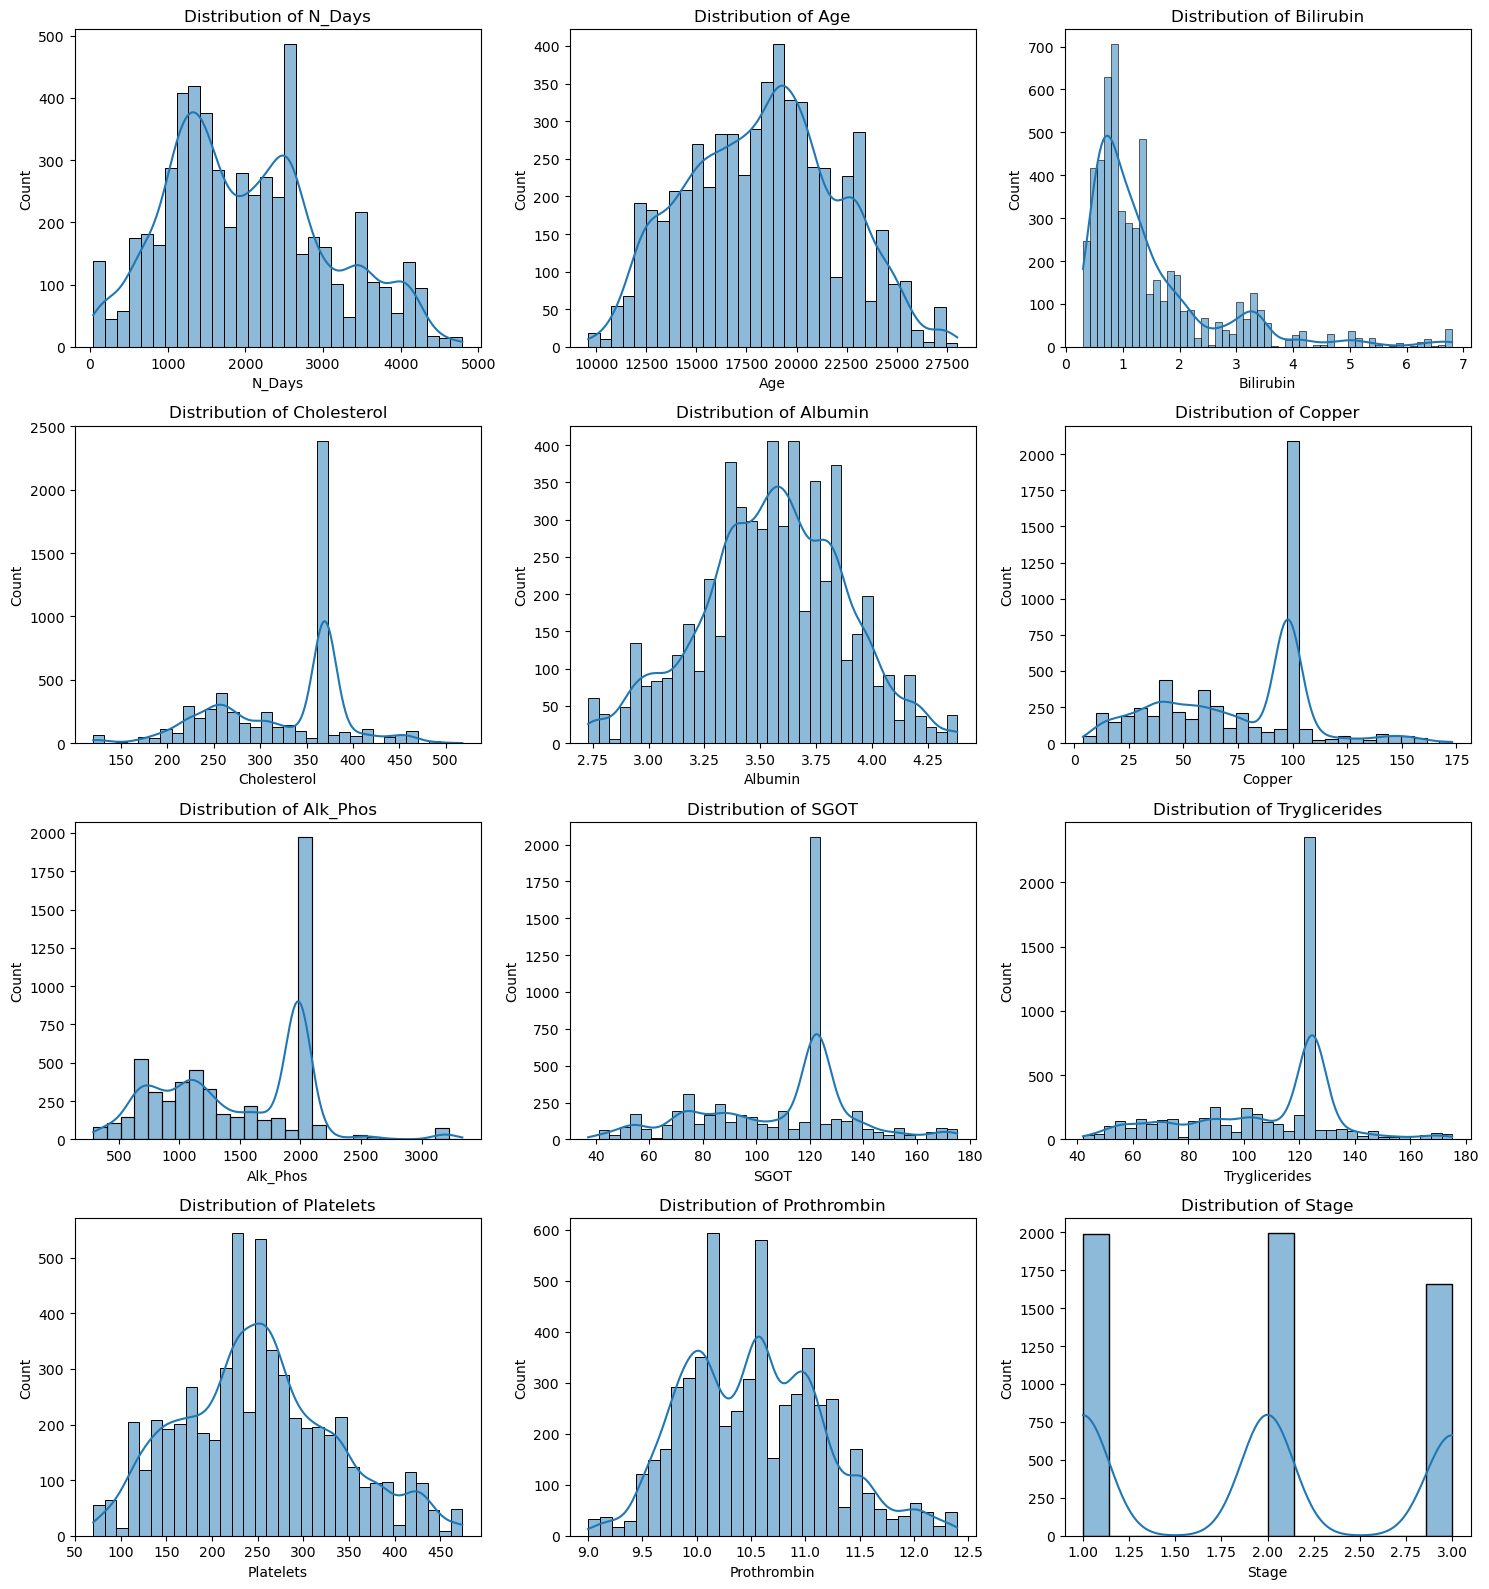

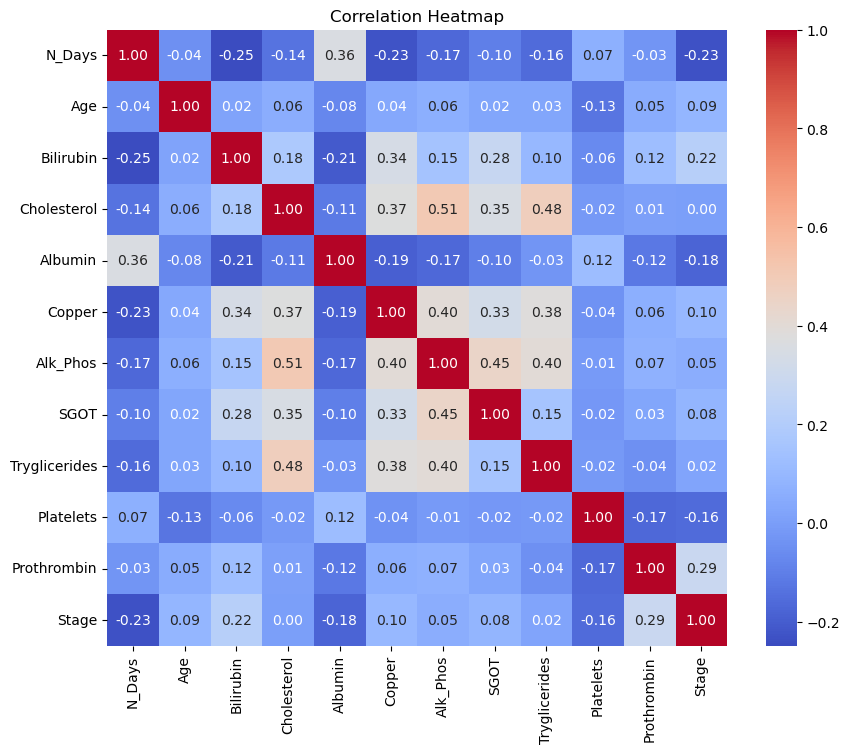

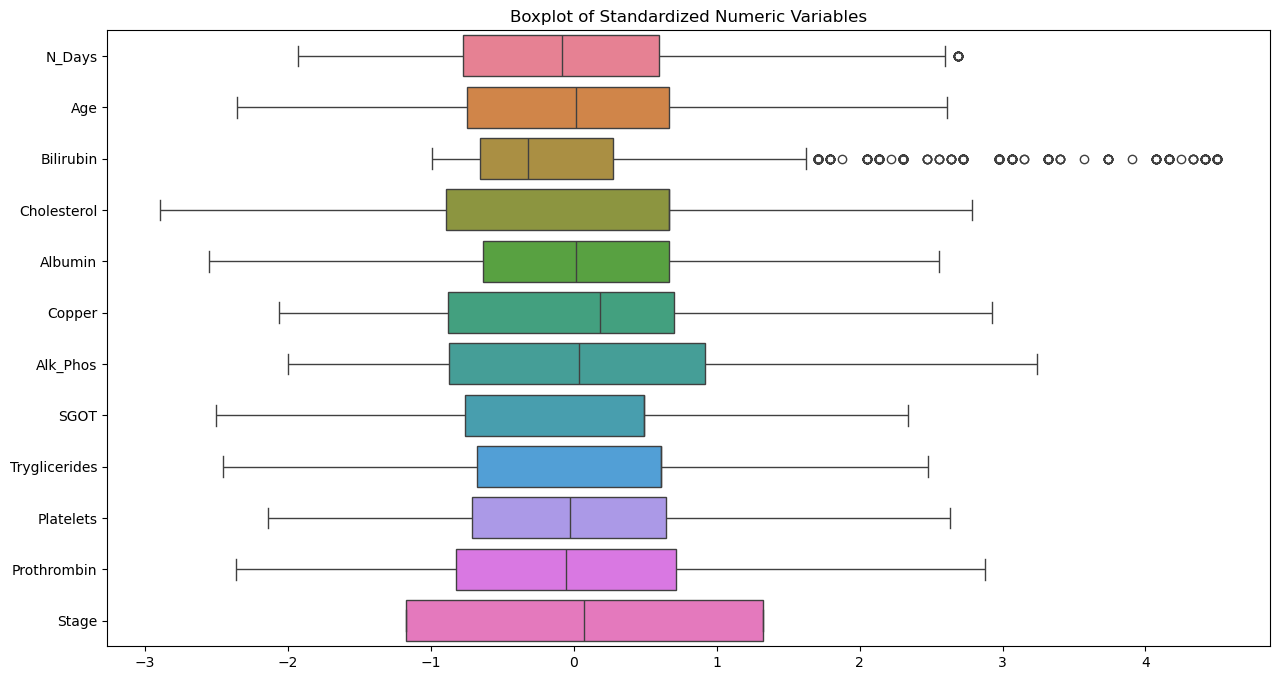

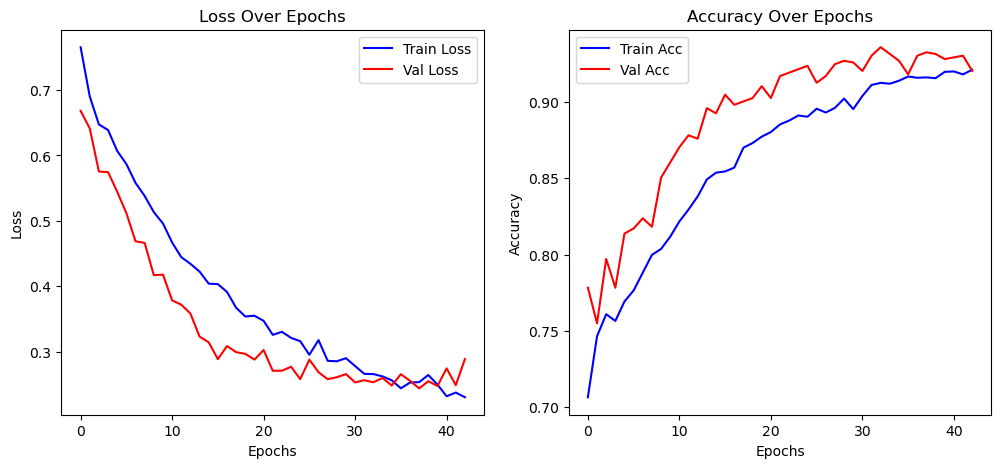

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report:
              precision    recall  f1-score   support

           c       0.93      0.96      0.95       781
          cl       0.85      0.79      0.82        66
           d       0.88      0.82      0.85       281

    accuracy                           0.92      1128
   macro avg       0.89      0.86      0.87      1128
weighted avg       0.92      0.92      0.92      1128



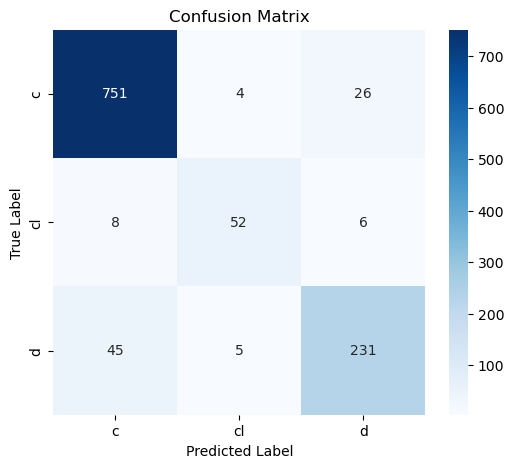

In [25]:
# Build the final model using the best hyperparameters from the tuner
final_model = tuner.hypermodel.build(best_hp)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the final model using a longer epoch schedule, if necessary
history = final_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=16,
                              validation_split=0.2,
                              callbacks=[early_stop],
                              verbose=1)
    
    # Evaluate on test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


   # Exploratory Data Visualization
plot_data_insights(df_raw)
    # Plot training history
plot_history(history)
    
    # Make predictions and evaluate performance
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Plot confusion matrix heatmap
plot_confusion_matrix(y_test, y_pred, label_encoder)